# Análise de Persona - Exploratória

#### Importando as bibliotecas

In [ ]:
import warnings

warnings.filterwarnings("ignore")


import io
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt

from xgboost import plot_importance, plot_tree

# from prophet import Prophet
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.preprocessing import StandardScaler

from dateutil.relativedelta import relativedelta
from calendar import monthrange
from datetime import datetime
from datetime import date

# pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)


def MAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


%load_ext lab_black
%matplotlib inline


class color:  # para formatar os prints
    PURPLE = "\033[95m"
    CYAN = "\033[96m"
    DARKCYAN = "\033[36m"
    BLUE = "\033[94m"
    GREEN = "\033[92m"
    YELLOW = "\033[93m"
    RED = "\033[91m"
    BOLD = "\033[1m"
    UNDERLINE = "\033[4m"
    END = "\033[0m"


print(color.BOLD + "Teste!" + color.END)

Teste!


<br>

#### Importando a base "Vendas"

Criada no Notebook "Cruzamentos_Propensao"

In [99]:
VENDAS = pd.read_csv(
    r"C:\Users\013809631\Box\Python_Scripts\Projeto_Oi_Tahto\Bases\Bases_Propensao/vendas.csv",
)

VENDAS.shape

(6904, 200)

<br>

#### Importando a base "BOV_FIBRA"

In [100]:
BOV_FIBRA = pd.read_csv(
    r"C:\Users\013809631\Box\Python_Scripts\Projeto_Oi_Tahto\Bases\Bases_Propensao\bov_full.csv",
    error_bad_lines=False,
    delimiter=";",
)

#### Analisando o cabeçalho, juntamente com a quantidade de linhas e colunas da base "BOV_FIBRA"

In [101]:
print(BOV_FIBRA.shape)
BOV_FIBRA.head()

(82657, 154)


,INDICADOR,PRODUTO,CANAL,PARCEIRO,OPERAÇÃO,ILHA,DT_ABERTURA,NUMERO_PEDIDO,TIPO,DATA_PEDIDO,STATUS,DATA_STATUS,NUM_IDENTIDADE,NOME_CLIENTE,TELEFONE_CONTATO,TIPO_LOGRADOURO_COBRANCA,NOME_LOGRADOURO_COBRANCA,NUMERO_COBRANCA,TIPO_LOGRADOURO_INSTALACAO,NOME_LOGRADOURO_INSTALACAO,NUMERO_INSTALACAO,BAIRRO_INSTALACAO,MUNICIPIO_INSTALACAO,ESTADO_INSTALACAO,CEP_INSTALACAO,NUM_LOCALIDADE,DDD_FIXO,NUMERO_FIXO,VELOCIDADE,LINHA_PRODUTO,NOME_CAMPANHA,NOME_OFERTA,CODIGO_SAP,LOGIN_VENDEDOR,PEDIDO_CRIADO_POR,NUMERO_DOCUMENTO,TIPO_PROMOCAO,ID_BUNDLE,IND_COMBO,PLANO_BUNDLE,TIPO_POSSE_COMBO,SIT_BUNDLE,FLG_MIG_COBRE_FIXO,FLG_MIG_COBRE_VELOX,TIPO_REDE,DT_FECHAMENTO,FLG_VENDA_VALIDA,UNIDADE_NEGOCIO,FLG_MIG_TV,REUSO_MANCHA,NOVA_UGR,LOGIN_OIT,MATRICULA_FINAL,PDV_NOVA_REGRA,CANAL_NOVA_REGRA,OPERACAO_NOVA_REGRA,PARCEIRO_NOVA_REGRA,DT_ABERTURA_NOVA_REGRA,LOGIN_VENDEDOR_NOVA_REGRA,CANAL_BOV_NOVA_REGRA,METODO_PAGAMENTO,PLANO,LOGIN_SIGLA,UF,STATUS OPERACIONAL,MATRICULA,NOME,CARGO,CARGO RESUMIDO,AVAYA,DIGITRO,SIP,TRISTERIX,PDS A,PDS C / D,ID TTV,UG TTV,COD. SETOR,SETOR,LOCAL,ENTRADA,JORNADA,TIPO JORNADA,DATA ADM,DATA RESC.,DESLIGAMENTO CAGED,MAT. SUP.,SUPERVISOR,MAT. COORD.,COORDENADOR,MAT. GER. LOCAL,GERENTE LOCAL,MAT. GER. REL.,GERENTE DE REL.,MAT. DIRETORIA,DIRETORIA,GH GIP,STATUS GIP,STATUS FPW,INICIO FÉRIAS,ÚLTIMO DIA FÉRIAS,INÍCIO AFAST.,RETORNO AFAST.,CURSO,DATA INÍCIO,DATA ENTREGA,TEM PARENTESCO,DATA DO INFORME,NORMA CONDUTA,CÓDIGO ÉTICA,POLÍTICA ANTICORRUPÇÃO,TI LIVRO 1,TI LIVRO 2,TI LIVRO 3,TERMO PACTUAÇÃO,FOTO GERADA,CRACHÁ GERADO,ABANDONO,ÚLTIMA ATUALIZAÇÃO,MTR USUARIO,ID STC,INFOMAÇÕES DAP,TIPO CUSTO,RATEIO CUSTO,RESP CUSTO,STATUS_FINANCEIRO,SUB SETOR,ILHA GA,EM HOME BASED,MATRICULA_BC,CD_MATRICULA,NO_NOME,DT_ADMISSAO,DT_RESCISAO,DH_ALTERACAO,NU_CPF,NO_PNE,DT_RESC_CAGED,NO_SEXO,NO_ESCOLARIDADE,DT_NASCIMENTO,NO_CIDADE,NU_CEP,NO_ESTADO_CIVIL,NO_RACA,NU_DEPENDENTES,NU_FILHOS_DEPENDENTES,NU_ASSIST_MEDICA,NU_ASSIST_ODONTO,IDADE,IDADE_FAIXA,TEMPO_EMPRESA,TEMPO_EMPRESA_YEAR,SEXO_CLIENTE
0,VL,BL FIBRA,WEB DIRETO TLV,BTCC,BTCC RES (WEB FORM FIBRA),FORMULÁRIO,2021-11-30,4-86068106305,Venda,20211130,Em Aprovisionamento,20211130,123123123,DANIEL MARINHO SERAPHIM,5.521985e+12,RUA,SEN DANTAS,117,RUA,SEN DANTAS,117,CENTRO,RIO DE JANEIRO,RJ,20031911,5000,21.0,24866251.0,400 MBPS,Fibra,NaN,BD_OITOTAL_VOIP+BL,1050774.0,NI,BRMRDBMS,5298357709,Oi Total,1-1RM2T3WM,MULTI,NaN,NaN,NaN,N,N,NI,NaN,S,VARRES,N,NaN,S,BC744647,NI,1050774.0,WEB DIRETO TLV,BTCC RES (WEB FORM FIBRA),BTCC,20211130.0,BC744647,WEB,1 - BOLETO,BANDA LARGA 400MBPS,BC,PR,ATIVO NO PISO,744647.0,PABLO EDUARDO GAONA,AGENTE DE CALL CENTER,AGENTE,0.0,0.0,88822.0,744647.0,0.0,0.0,744647.0,1679.0,1679.0,WEB FORMULARIO VENDAS VAREJO,MERCÊS – BLOCO BH-4º ANDAR- SALA 0,07:00:00,06:20:00,180 HORAS MENSAIS,2019-07-18,NaN,NaN,695667.0,RAFAEL JOSE ZEM,768711.0,THIAGO ARANTES REZENDE,768858.0,ELI MOISES DE FREITAS ROCHA,768858.0,ELI MOISES DE FREITAS ROCHA,758259.0,DANYELLE PERPETUO DE ALMEIDA MARTINS,12.2576.2216.8107.8596.8300.8210.6384,ATIVIDADE NORMAL,ATIVIDADE NORMAL,05/01/2022,03/02/2022,NaN,NaN,-,NaN,NaN,NAO TEM PARENTES,22/07/2019 10:00:48,09/04/2021 18:51:53,22/07/2019 09:57:43,22/07/2019 09:56:28,NaN,NaN,NaN,NÃO,11/07/2019 10:31:32,19/07/2019 09:41:26,NÃO,27/09/2021 16:23:53,695220.0,H68796,-,MOD-D,SEM RATEIO,-,APROVADO,WEB FORMULARIO VENDAS VAREJO/NIVEL 1,FORMULARIO,SIM,BC744647,744647.0,PABLO EDUARDO GAONA,2019-07-18 00:00:00,1900-01-01 00:00:00,2021-12-22 07:43:14,1.149443e+10,N,1900-01-01 00:00:00,M,ENSINO MÉDIO COMPLETO,1997-01-22 00:00:00,CURITIBA,81670090.0,?,?,0.0,0.0,0.0,0.0,24,21-25,893 days,2,M
1,VL,FIXO FIBRA,WEB DIRETO TLV,BTCC,BTCC (FIBRA DIGITAL PAV),PA VIRTUAL,2021-11-30,4-86112363557,Venda,20211130,Em Aprovisionamento,20211130,000,JOANA NUNES WIEDENHOFT,5.551998e+12,RUA,VSC DE TAUNAY,370,RUA,VSC DE TAUNAY,370,HARMONIA,CANOAS,RS,92310550,4450,51.0,34683781.0,NaN,Fibra,NaN,BD_OITOTAL_VOIP+BL,1055735.0,NI,BRMRDBMS,4336699003,Oi Total,1-1RMAY3UL,MULTI,NaN,NaN,NaN,N,N,NI,NaN,S,VARRES,N,NaN,S,BC7

<br>

#### Importando a base "RETORNO_BASE"

In [102]:
RETORNO_BASE = pd.read_csv(
    r"C:\Users\013809631\Box\Python_Scripts\Projeto_Oi_Tahto\Bases\Bases_Propensao\RetornoBase2.csv",
    delimiter=",",
    encoding="ISO-8859-1",
)

RETORNO_BASE.shape

(5073252, 12)

#### Analisando o cabeçalho, juntamente com a quantidade de linhas e colunas da base "RETORNO_BASE"

In [298]:
print(RETORNO_BASE.shape)
RETORNO_BASE.head()

(5073252, 12)


,CAMPANHA,COD_MAILING,COD_CHAVE_CONTATO,DDD_E_TELEFONE_DISCADO,COD_ARVORE_MOTIVO,NOME_PRODUTO,DT_EVENTO_INI,DT_EVENTO_FIM,MATR_ATENDENTE,MATR_SUPERVISOR,CPF_CNPJ,DATA_CARGA
0,TLV_ATV_FIBRA,3-0000102147,55996294454,55996294454,10000000352,FIBRA,2021-11-06 16:01:26,2021-11-06 16:01:26,0,NaN,1717628001,2021-11-06 16:06:34
1,TLV_NOVAFIBRA_ATIVO,3-0000102144,21991819829,19994407516,10000000269,FIBRA,2021-11-03 13:53:51,2021-11-03 13:53:51,0,NaN,6446355688,2021-11-03 21:08:37
2,CAMP_FIBRA_CARB4,3-0000102461,69999492502,21969079950,10000000007,FIBRA,2021-11-19 15:47:20,2021-11-19 15:47:20,0,NaN,53930185253,2021-11-19 15:51:41
3,ATIV_FIBRAGUERRILHA,3-0000102111,41984511196,41985535390,10000000007,FIBRA,2021-11-08 10:21:11,2021-11-08 10:21:11,0,NaN,76815552934,2021-11-08 10:36:42
4,ATIV_FIBRAGUERRILHA,3-0000102111,98987575873,98987575873,10000000268,FIBRA,2021-11-08 20:26:07,2021-11-08 20:26:07,0,NaN,17616905315,2021-11-08 20:31:13


<br>

#### Importando a base "DE_PARA"

In [103]:
DE_PARA = pd.read_excel(r"C:\Users\013809631\Downloads\Deparagenesysbasecomp2.xlsx")

DE_PARA.shape

(271, 4)

#### Analisando o cabeçalho, juntamente com a quantidade de linhas e colunas da base "DE_PARA"

In [300]:
print(DE_PARA.shape)
DE_PARA.head()

(271, 4)


,COD_RETORNO,NOME_PRODUTO,NOME_GRUPO,MOTIVO
0,10000000012,RECUSA - CLIENTE,CLIENTE DESLIGOU / RECUSOU CONTATO ...,?
1,10000000300,Solicitação de C,NÃO QUALIFICADO ...,?
2,10000000052,NÃO QUALIFICADO,EPS NÃO QUALIFICOU O REGISTRO ...,?
3,10000000008,RECUSA - OI,CLIENTE INADIMPLENTE / RESTRIÇÃO DE CRÉDITO ...,?
4,10000000005,TELEFONIA,"PROBLEMAS CHAMADA (LINHA MUDA, DESCONECTADA, B...",?


<br>

#### Iniciando os cruzamentos entre as bases importadas

<br>

#### Cruzando as bases "RETORNO_BASE" com "DE_PARA"

    Chave da base "RETORNO_BASE" = "COD_ARVORE_MOTIVO"
    Chave da base "DE_PARA" = "COD_RETORNO"

In [104]:
RETORNO_DE_PARA = RETORNO_BASE.merge(
    DE_PARA,
    left_on=["COD_ARVORE_MOTIVO"],
    right_on=["COD_RETORNO"],
    how="left",
    suffixes=("_left", "_right"),
)

RETORNO_DE_PARA.shape

(5073252, 16)

<br>

#### Cruzando as bases "BOV_FIBRA" com "RETORNO_DE_PARA"

    Chave da base "BOV_FIBRA" = "NUMERO_DOCUMENTO"
    Chave da base "RETORNO_DE_PARA" = "CPF_CNPJ"

In [301]:
BOV_FULL = BOV_FIBRA.merge(
    RETORNO_DE_PARA,
    left_on=["NUMERO_DOCUMENTO"],
    right_on=["CPF_CNPJ"],
    how="left",
    suffixes=("_left", "_right"),
)

BOV_FULL.shape

(91762, 170)

#### Filtrando a base "BOV_FULL_FILTRADA"

Filtrando apenas as 3 colunas que iremos utilizar dessa base. "NUMERO_DOCUMENTO" e "CPF_CNPJ" serão chaves para cruzarmos, enquanto a coluna "SEXO_CLIENTE" será utilizada para as futuras análises

In [108]:
BOV_FULL_FILTRADA = BOV_FULL[["NUMERO_DOCUMENTO", "CPF_CNPJ", "SEXO_CLIENTE"]]

<br>

#### Cruzando as bases "VENDAS" com "BOV_FULL_FILTRADA"

    Chaves da base "BOV_FIBRA" = "NUMERO_DOCUMENTO", "CPF_CNPJ"
    Chaves da base "RETORNO_DE_PARA" = "NUMERO_DOCUMENTO", "CPF_CNPJ"

In [109]:
df = VENDAS.merge(
    BOV_FULL_FILTRADA,
    left_on=["NUMERO_DOCUMENTO", "CPF_CNPJ"],
    right_on=["NUMERO_DOCUMENTO", "CPF_CNPJ"],
    # how="left",
    suffixes=("_left", "_right"),
)

df.shape

(165688, 201)

#### Deletando as duplicatas da base final de vendas

In [204]:
df = df.drop_duplicates(keep="first")
df.shape

(6904, 201)

#### Deletando uma coluna com erro

In [297]:
df.drop(columns=["Unnamed: 0"], inplace=True)

#### Deletando os nulos da coluna "DT_EVENTO_INI"

In [223]:
df = df.dropna(axis=0, subset=["DT_EVENTO_INI"])
df.shape

(6644, 201)

#### Tratando e criando novas colunas para a base final

Primeiramente transformamos a coluna "DT_EVENTO_INI" para datetime, após isso, apartir dela, criamos as colunas de Hora e Dia da semana

In [259]:
df["DT_EVENTO_INI"] = df["DT_EVENTO_INI"].apply(
    lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
)

df["HOUR"] = df.DT_EVENTO_INI.dt.hour

df["DAY_OF_WEEK"] = df.DT_EVENTO_INI.dt.dayofweek

#### Criando um Dataframe agrupado por Ilha, Sexo, Status e soma da quantidade de vendas (filtrando o Status para "Concluído")

In [231]:
venda = (
    df.groupby(["ILHA", "SEXO_CLIENTE", "STATUS"])
    .agg({"TIPO": "count"})
    .rename(columns={"TIPO": "qtd_vendas"})
)

venda = venda.groupby(level=0).apply(lambda x: round(100 * x / float(x.sum()), 1))
venda = venda.reset_index()

venda = venda[venda["STATUS"] == "Concluído"]
venda

,ILHA,SEXO_CLIENTE,STATUS,qtd_vendas
1,FIBRA,F,Concluído,33.3
4,FIBRA,M,Concluído,46.3
7,PA VIRTUAL,F,Concluído,29.2
10,PA VIRTUAL,M,Concluído,50.0


#### Declarando esta função para plotar os números em cima das barras nos gráficos em diante

In [191]:
def show_values(axs, orient="v", space=0.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height() * 0.01)
                value = "{:.1f}".format(p.get_height())
                ax.text(_x, _y, value, ha="center")
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height() * 0.5)
                value = "{:.1f}".format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

## Percentual de vendas concluídas por Ilha & Sexo

Quantidade de vendas totais por Sexo (Percentual):


M    58.712542
F    41.287458
Name: SEXO_CLIENTE, dtype: float64


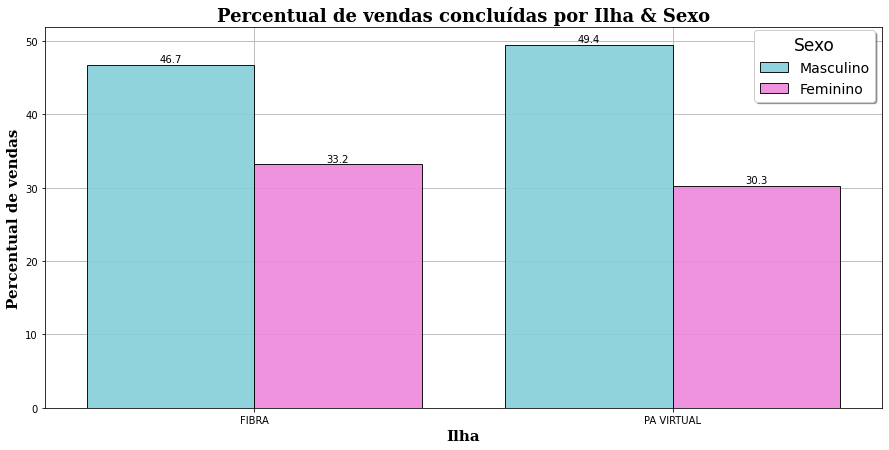

In [202]:
df_concluido = df[df["STATUS"] == "Concluído"]

print(color.BOLD + "Quantidade de vendas totais por Sexo (Percentual):" + color.END)
print("\n")
print(df_concluido["SEXO_CLIENTE"].value_counts(normalize=True) * 100)

plt.figure(figsize=(15, 7))

hue_order = venda["SEXO_CLIENTE"].value_counts()[["M", "F"]]

g = sns.barplot(
    x="ILHA",
    y="qtd_vendas",
    hue="SEXO_CLIENTE",
    data=venda,
    hue_order=hue_order.index,
    edgecolor="black",
    linewidth=1,
    alpha=0.9,
    zorder=3,
    palette={"M": "#77dae7", "F": "#ff76e7",},
)

show_values(g)

plt.grid(True, zorder=0)

plt.title(
    "Percentual de vendas concluídas por Ilha & Sexo",
    fontdict={"family": "serif", "color": "black", "weight": "bold", "size": 18},
)
plt.xlabel(
    "Ilha",
    fontdict={"family": "serif", "color": "black", "weight": "bold", "size": 15},
)
plt.ylabel(
    "Percentual de vendas",
    fontdict={"family": "serif", "color": "black", "weight": "bold", "size": 15},
)

L = plt.legend(
    loc="upper right",
    fontsize=14,
    fancybox=True,
    shadow=True,
    bbox_to_anchor=(1, 1.01),
)
L.set_title("Sexo", prop={"size": 17})
L.get_texts()[0].set_text("Masculino")
L.get_texts()[1].set_text("Feminino")

#### Criando um Dataframe agrupado por Hora, Sexo, Status e soma da quantidade de vendas (filtrando o Status para "Concluído")

In [233]:
hora = (
    df.groupby(["HOUR", "SEXO_CLIENTE", "STATUS"])
    .agg({"TIPO": "count"})
    .rename(columns={"TIPO": "qtd_vendas"})
)

hora = hora.groupby(level=0).apply(lambda x: round(100 * x / float(x.sum()), 1))
hora = hora.reset_index()

hora = hora[hora["STATUS"] == "Concluído"]
hora.head()

,HOUR,SEXO_CLIENTE,STATUS,qtd_vendas
2,9,F,Concluído,41.8
5,9,M,Concluído,45.1
8,10,F,Concluído,35.6
11,10,M,Concluído,42.8
14,11,F,Concluído,36.3


## Percentual de vendas concluídas por Hora & Sexo

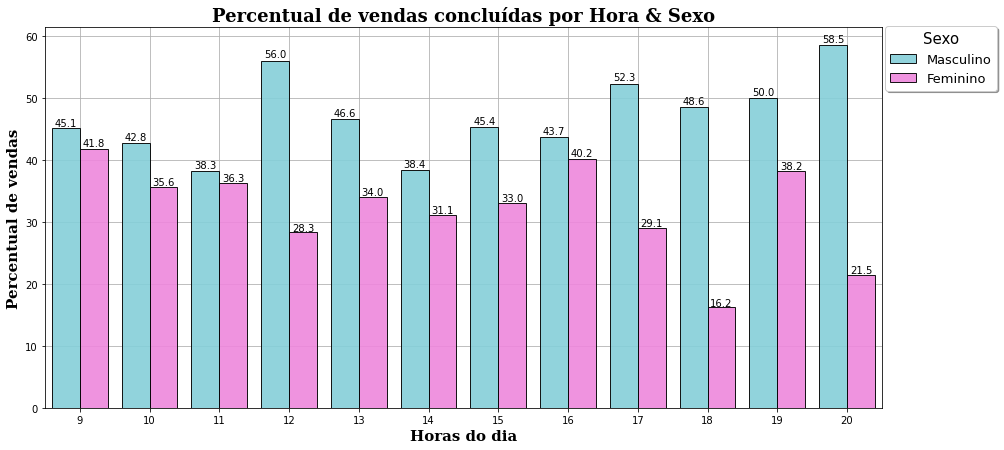

In [250]:
plt.figure(figsize=(15, 7))

g = sns.barplot(
    x="HOUR",
    y="qtd_vendas",
    hue="SEXO_CLIENTE",
    data=hora,
    hue_order=hue_order.index,
    edgecolor="black",
    linewidth=1,
    alpha=0.9,
    zorder=3,
    palette={"M": "#77dae7", "F": "#ff76e7",},
)

plt.grid(True, zorder=0)

plt.title(
    "Percentual de vendas concluídas por Hora & Sexo",
    fontdict={"family": "serif", "color": "black", "weight": "bold", "size": 18},
)
plt.xlabel(
    "Horas do dia",
    fontdict={"family": "serif", "color": "black", "weight": "bold", "size": 15},
)
plt.ylabel(
    "Percentual de vendas",
    fontdict={"family": "serif", "color": "black", "weight": "bold", "size": 15},
)

show_values(g)

L = plt.legend(
    loc="upper right",
    fontsize=13,
    fancybox=True,
    shadow=True,
    bbox_to_anchor=(1.145, 1.02),
)
L.set_title("Sexo", prop={"size": 15})
L.get_texts()[0].set_text("Masculino")
L.get_texts()[1].set_text("Feminino")

#### Criando um Dataframe agrupado por Dia da semana, Sexo, Status e soma da quantidade de vendas (filtrando o Status para "Concluído")

In [260]:
day_of_wek = (
    df.groupby(["DAY_OF_WEEK", "SEXO_CLIENTE", "STATUS"])
    .agg({"TIPO": "count"})
    .rename(columns={"TIPO": "qtd_vendas"})
)

day_of_wek = day_of_wek.groupby(level=0).apply(
    lambda x: round(100 * x / float(x.sum()), 1)
)
day_of_wek = day_of_wek.reset_index()

day_of_wek = day_of_wek[day_of_wek["STATUS"] == "Concluído"]
day_of_wek.head()

,DAY_OF_WEEK,SEXO_CLIENTE,STATUS,qtd_vendas
1,0,F,Concluído,29.5
4,0,M,Concluído,49.1
7,1,F,Concluído,38.5
10,1,M,Concluído,42.1
13,2,F,Concluído,33.1


## Percentual de vendas concluídas por Dia da semana & Sexo

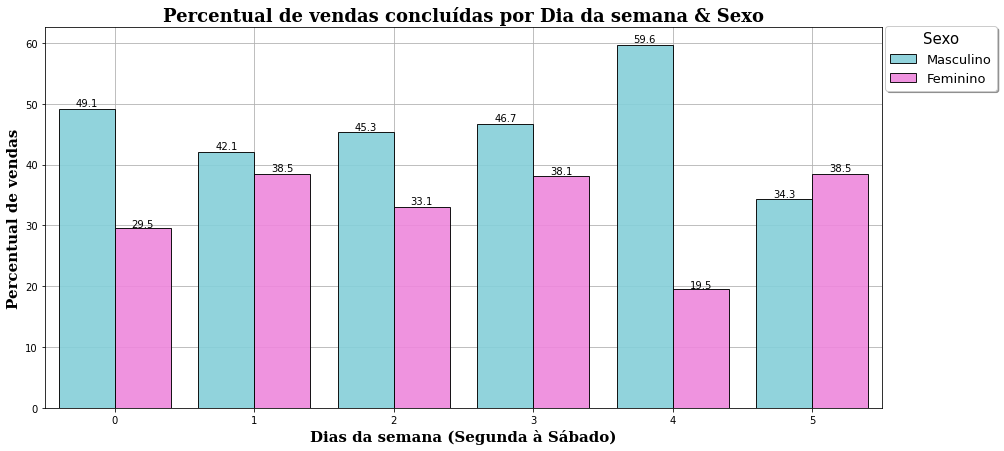

In [263]:
plt.figure(figsize=(15, 7))

g = sns.barplot(
    x="DAY_OF_WEEK",
    y="qtd_vendas",
    hue="SEXO_CLIENTE",
    data=day_of_wek,
    hue_order=hue_order.index,
    edgecolor="black",
    linewidth=1,
    alpha=0.9,
    zorder=3,
    palette={"M": "#77dae7", "F": "#ff76e7",},
)

plt.grid(True, zorder=0)

plt.title(
    "Percentual de vendas concluídas por Dia da semana & Sexo",
    fontdict={"family": "serif", "color": "black", "weight": "bold", "size": 18},
)
plt.xlabel(
    "Dias da semana (Segunda à Sábado)",
    fontdict={"family": "serif", "color": "black", "weight": "bold", "size": 15},
)
plt.ylabel(
    "Percentual de vendas",
    fontdict={"family": "serif", "color": "black", "weight": "bold", "size": 15},
)

show_values(g)

L = plt.legend(
    loc="upper right",
    fontsize=13,
    fancybox=True,
    shadow=True,
    bbox_to_anchor=(1.145, 1.02),
)
L.set_title("Sexo", prop={"size": 15})
L.get_texts()[0].set_text("Masculino")
L.get_texts()[1].set_text("Feminino")

#### Criando um Dataframe agrupado por OBS5, STATUS e soma da quantidade de vendas (filtrando o Status para "Concluído")

In [293]:
OBS = (
    df.groupby(["OBS5", "STATUS"])
    .agg({"TIPO": "count"})
    .rename(columns={"TIPO": "qtd_vendas"})
)

OBS = OBS.reset_index()

OBS = OBS[OBS["STATUS"] == "Concluído"]
OBS = OBS.sort_values(["qtd_vendas"], ascending=False)
OBS.head()

,OBS5,STATUS,qtd_vendas
28,PROPENSAO =4,Concluído,992
31,PROPENSAO =5,Concluído,764
25,PROPENSAO =3,Concluído,618
22,PROPENSAO =2,Concluído,592
34,PROPENSAO =6,Concluído,560


## Valor absoluto de vendas concluídas por OBS

Text(0, 0.5, "OBS's")

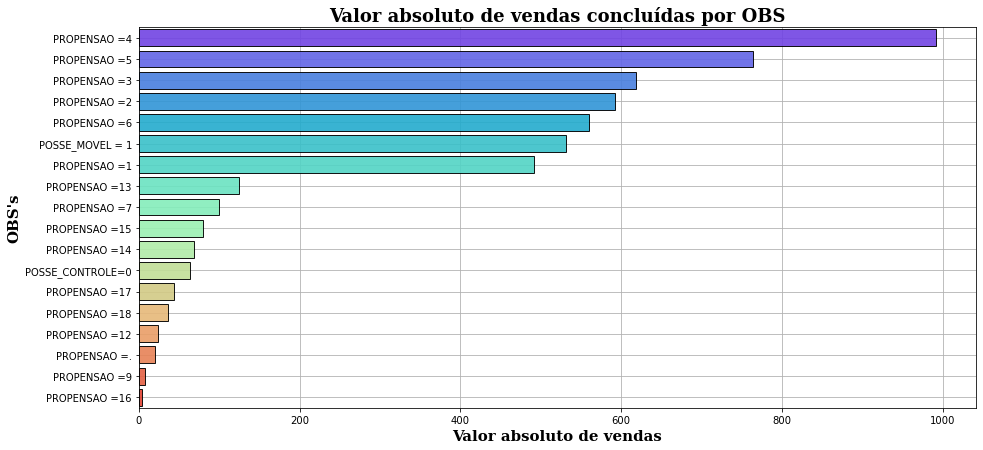

In [295]:
plt.figure(figsize=(15, 7))

g = sns.barplot(
    x="qtd_vendas",
    y="OBS5",
    data=OBS,
    edgecolor="black",
    linewidth=1,
    alpha=0.9,
    zorder=3,
    palette="rainbow",
)

plt.grid(True, zorder=0)

plt.title(
    "Valor absoluto de vendas concluídas por OBS",
    fontdict={"family": "serif", "color": "black", "weight": "bold", "size": 18},
)
plt.xlabel(
    "Valor absoluto de vendas",
    fontdict={"family": "serif", "color": "black", "weight": "bold", "size": 15},
)
plt.ylabel(
    "OBS's",
    fontdict={"family": "serif", "color": "black", "weight": "bold", "size": 15},
)

#### Criando um Dataframe agrupado por UF, STATUS e soma da quantidade de vendas (filtrando o Status para "Concluído")

In [308]:
UF = (
    df.groupby(["SGUF", "STATUS"])
    .agg({"TIPO": "count"})
    .rename(columns={"TIPO": "qtd_vendas"})
)

UF = UF.reset_index()

UF = UF[UF["STATUS"] == "Concluído"]
UF = UF.sort_values(["qtd_vendas"], ascending=False)
UF.head()

,SGUF,STATUS,qtd_vendas
43,RJ,Concluído,1012
40,PR,Concluído,712
50,RS,Concluído,492
16,ES,Concluído,412
13,DF,Concluído,386


## Valor absoluto de vendas por UF

Text(0, 0.5, 'Valor absoluto de vendas')

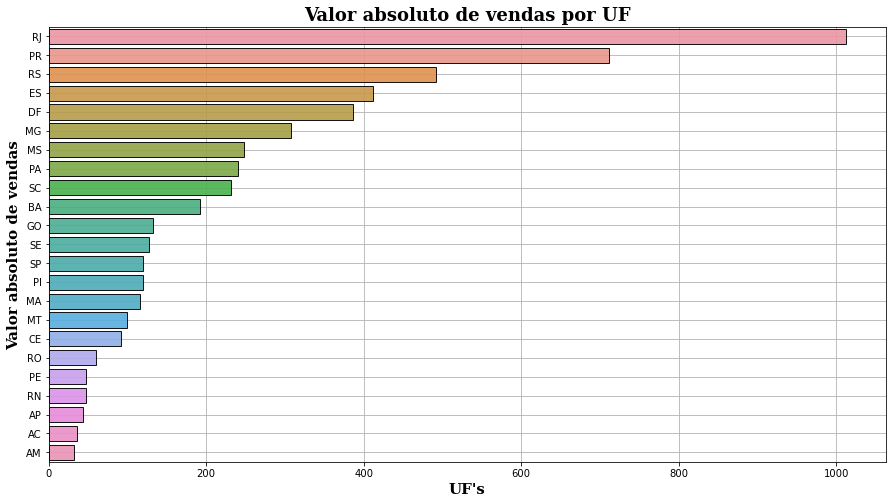

In [333]:
plt.figure(figsize=(15, 8))

sns.barplot(
    x="qtd_vendas",
    y="SGUF",
    data=UF,
    hue_order=hue_order.index,
    edgecolor="black",
    linewidth=1,
    alpha=0.9,
    zorder=3,
)

plt.grid(True, zorder=0)

plt.title(
    "Valor absoluto de vendas por UF",
    fontdict={"family": "serif", "color": "black", "weight": "bold", "size": 18},
)
plt.xlabel(
    "UF's",
    fontdict={"family": "serif", "color": "black", "weight": "bold", "size": 15},
)
plt.ylabel(
    "Valor absoluto de vendas",
    fontdict={"family": "serif", "color": "black", "weight": "bold", "size": 15},
)

#### Criando um Dataframe agrupado por Municipio, STATUS e soma da quantidade de vendas (filtrando o Status para "Concluído")

In [329]:
NM_MUNICIPIO = (
    df.groupby(["NOMEMUNICIPIO", "STATUS"])
    .agg({"TIPO": "count"})
    .rename(columns={"TIPO": "qtd_vendas"})
)

NM_MUNICIPIO = NM_MUNICIPIO.reset_index()

NM_MUNICIPIO = NM_MUNICIPIO[NM_MUNICIPIO["STATUS"] == "Concluído"]
NM_MUNICIPIO = NM_MUNICIPIO.sort_values(["qtd_vendas"], ascending=False)
NM_MUNICIPIO = NM_MUNICIPIO.head(15)

## Valor absoluto de vendas por Município

Text(0, 0.5, 'Valor absoluto de vendas')

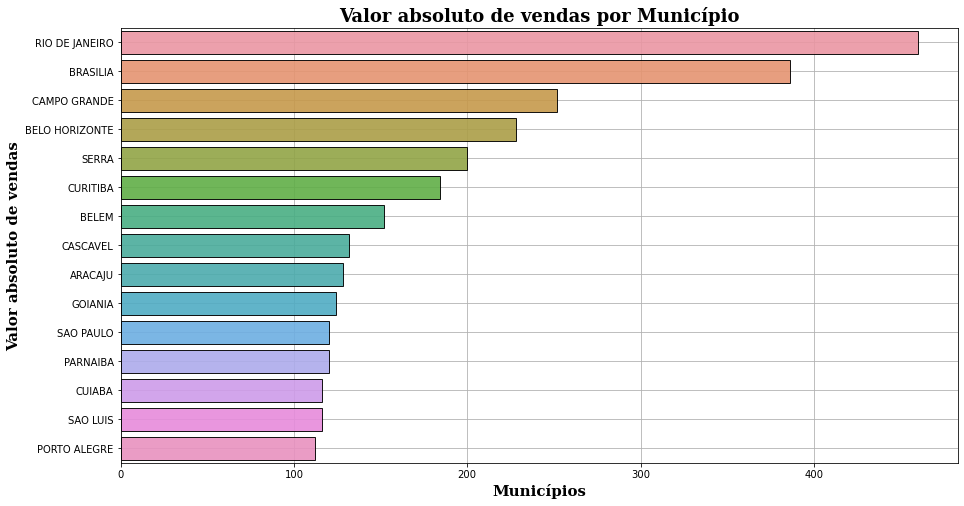

In [334]:
plt.figure(figsize=(15, 8))

g = sns.barplot(
    x="qtd_vendas",
    y="NOMEMUNICIPIO",
    data=NM_MUNICIPIO,
    edgecolor="black",
    linewidth=1,
    alpha=0.9,
    zorder=3,
)

plt.grid(True, zorder=0)

plt.title(
    "Valor absoluto de vendas por Município",
    fontdict={"family": "serif", "color": "black", "weight": "bold", "size": 18},
)
plt.xlabel(
    "Municípios",
    fontdict={"family": "serif", "color": "black", "weight": "bold", "size": 15},
)
plt.ylabel(
    "Valor absoluto de vendas",
    fontdict={"family": "serif", "color": "black", "weight": "bold", "size": 15},
)

#### Criando um Dataframe agrupado por Oferta, STATUS e soma da quantidade de vendas (filtrando o Status para "Concluído")

In [344]:
NM_OFERTA = (
    df.groupby(["NOME_OFERTA", "STATUS"])
    .agg({"TIPO": "count"})
    .rename(columns={"TIPO": "qtd_vendas"})
)

NM_OFERTA = NM_OFERTA.reset_index()

NM_OFERTA = NM_OFERTA[NM_OFERTA["STATUS"] == "Concluído"]
NM_OFERTA = NM_OFERTA.sort_values(["qtd_vendas"], ascending=False)
NM_OFERTA

,NOME_OFERTA,STATUS,qtd_vendas
1,BD_OITOTAL_VOIP+BL,Concluído,5280
4,BD_OITOTAL_VOIP+BL+IPTV,Concluído,30


## Valor absoluto de vendas por Oferta

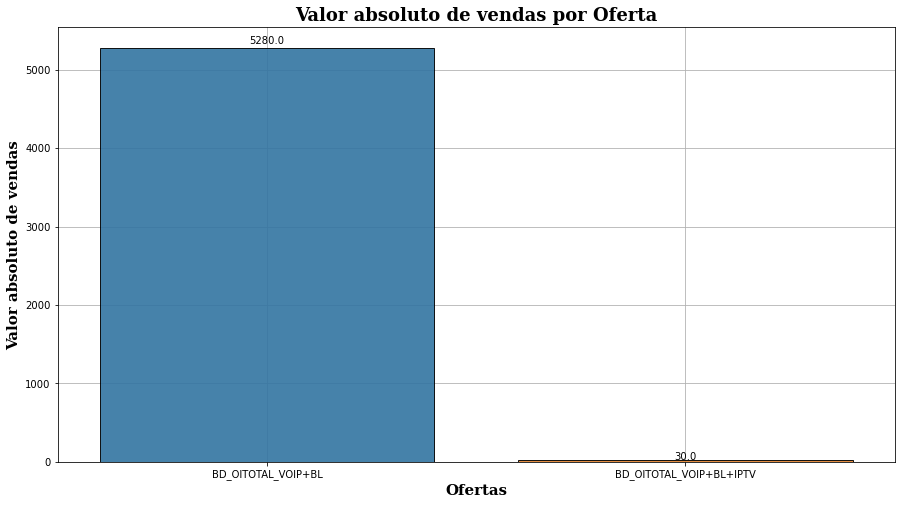

In [345]:
plt.figure(figsize=(15, 8))

g = sns.barplot(
    x="NOME_OFERTA",
    y="qtd_vendas",
    data=NM_OFERTA,
    edgecolor="black",
    linewidth=1,
    alpha=0.9,
    zorder=3,
)

plt.grid(True, zorder=0)

plt.title(
    "Valor absoluto de vendas por Oferta",
    fontdict={"family": "serif", "color": "black", "weight": "bold", "size": 18},
)
plt.xlabel(
    "Ofertas",
    fontdict={"family": "serif", "color": "black", "weight": "bold", "size": 15},
)
plt.ylabel(
    "Valor absoluto de vendas",
    fontdict={"family": "serif", "color": "black", "weight": "bold", "size": 15},
)

show_values(g)

#### Criando um Dataframe agrupado por Ilha, Bundle, STATUS e soma da quantidade de vendas (filtrando o Status para "Concluído")

In [349]:
PL_BUNDLE = (
    df.groupby(["ILHA", "PLANO_BUNDLE", "STATUS"])
    .agg({"TIPO": "count"})
    .rename(columns={"TIPO": "qtd_vendas"})
)

PL_BUNDLE = PL_BUNDLE.reset_index()

PL_BUNDLE = PL_BUNDLE[PL_BUNDLE["STATUS"] == "Concluído"]
PL_BUNDLE = PL_BUNDLE.sort_values(["qtd_vendas"], ascending=False)
PL_BUNDLE

,ILHA,PLANO_BUNDLE,STATUS,qtd_vendas
3,FIBRA,OI TOTAL FIXO + BANDA LARGA 1 NA CONTA,Concluído,4588
10,PA VIRTUAL,OI TOTAL FIXO + BANDA LARGA 1 NA CONTA,Concluído,372
6,FIBRA,OI TOTAL FIXO + BANDA LARGA 2 NA CONTA,Concluído,228
12,PA VIRTUAL,OI TOTAL FIXO + BANDA LARGA 2 NA CONTA,Concluído,40
1,FIBRA,OI TOTAL FIXO + BANDA LARGA + TV 3 NA CONTA,Concluído,30
8,FIBRA,OI TOTAL FIXO + POS CONECTADO 500 + BANDA LARG...,Concluído,20


## Valor absoluto de vendas por Bundle

Text(0, 0.5, 'Bundles')

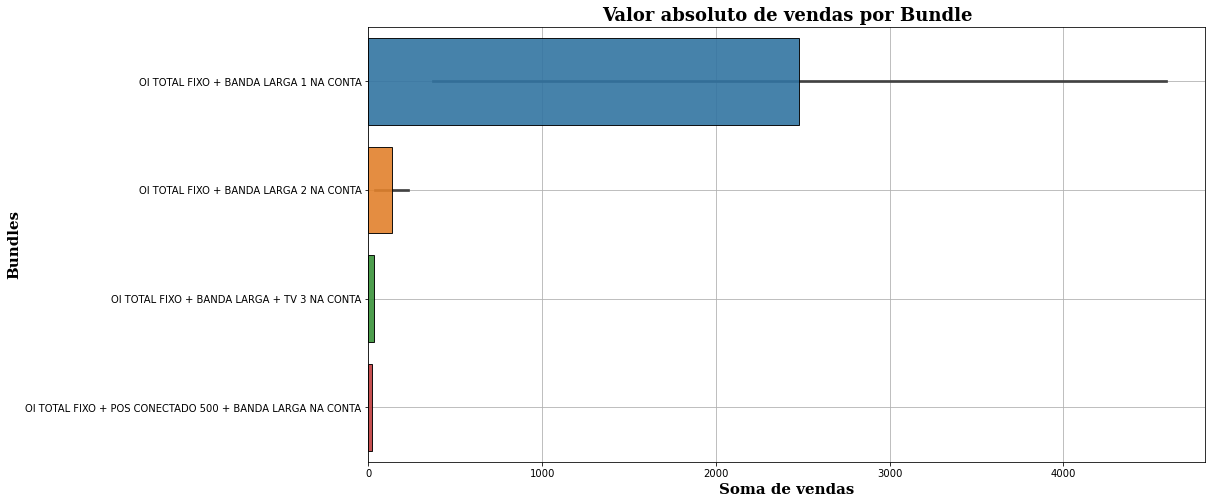

In [351]:
plt.figure(figsize=(15, 8))

g = sns.barplot(
    x="qtd_vendas",
    y="PLANO_BUNDLE",
    data=PL_BUNDLE,
    edgecolor="black",
    linewidth=1,
    alpha=0.9,
    zorder=3,
)

plt.grid(True, zorder=0)

plt.title(
    "Valor absoluto de vendas por Bundle",
    fontdict={"family": "serif", "color": "black", "weight": "bold", "size": 18},
)
plt.xlabel(
    "Soma de vendas",
    fontdict={"family": "serif", "color": "black", "weight": "bold", "size": 15},
)
plt.ylabel(
    "Bundles",
    fontdict={"family": "serif", "color": "black", "weight": "bold", "size": 15},
)

<br>
<hr>